In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import accuracy_score #metrics

#tools for hyperparameters search
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


df = pd.read_csv('./data/bank-balanced.csv')
term_deposits = df.copy()
# Have a grasp of how our data looks.
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [3]:
df.shape

(11162, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


## EDA

In [5]:
df.describe()

age       balance           day      duration      campaign  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948   1528.538524     15.658036    371.993818      2.508421   
std       11.913369   3225.413326      8.420740    347.128386      2.722077   
min       18.000000  -6847.000000      1.000000      2.000000      1.000000   
25%       32.000000    122.000000      8.000000    138.000000      1.000000   
50%       39.000000    550.000000     15.000000    255.000000      2.000000   
75%       49.000000   1708.000000     22.000000    496.000000      3.000000   
max       95.000000  81204.000000     31.000000   3881.000000     63.000000   

              pdays      previous  
count  11162.000000  11162.000000  
mean      51.330407      0.832557  
std      108.758282      2.292007  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       20.750000      1.000000  
max      854.000000     58.000000

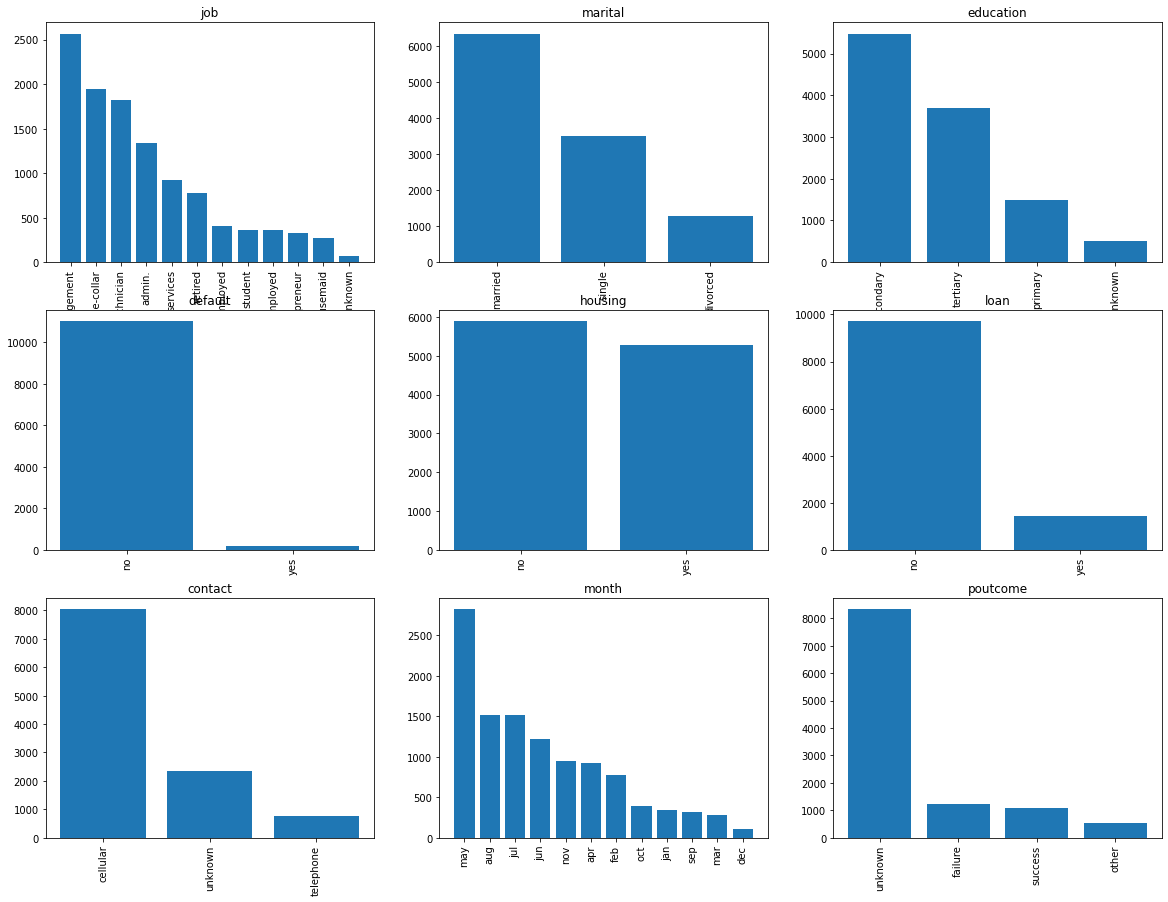

In [6]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for cat_column in cat_columns:
    value_counts = df[cat_column].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

In [7]:
df.deposit.value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

<AxesSubplot:xlabel='education', ylabel='balance'>

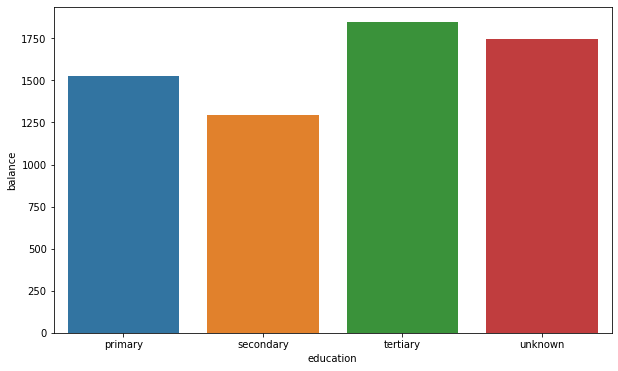

In [8]:
edu_balance = df.groupby('education')['balance'].mean()
job_balance = df.groupby('job')['balance'].mean()
edu = df.groupby('education')['balance'].count()
plt.figure(figsize=(10,6))
sns.barplot(edu_balance.index,edu_balance)

In [9]:
edu/df.shape[0]

education
primary      0.134385
secondary    0.490593
tertiary     0.330496
unknown      0.044526
Name: balance, dtype: float64

<AxesSubplot:xlabel='job', ylabel='balance'>

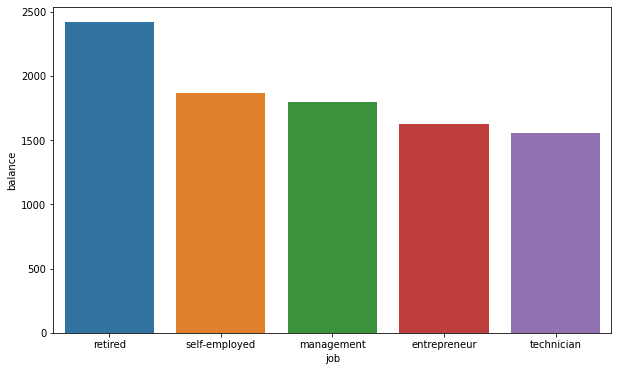

In [10]:
job_balance_top5 = job_balance.sort_values(ascending = False).iloc[[0,2,3,4,5]]
plt.figure(figsize=(10,6))
sns.barplot(job_balance_top5.index,job_balance_top5)

In [11]:
df.default.value_counts()/df.shape[0]

no     0.984949
yes    0.015051
Name: default, dtype: float64

In [12]:
df.groupby('default')['balance'].mean()

default
no     1552.840640
yes     -61.803571
Name: balance, dtype: float64

In [13]:
df_default = df.loc[df.default == 'yes']

In [14]:
df_default.groupby('education').count()

age  job  marital  default  balance  housing  loan  contact  day  \
education                                                                     
primary     29   29       29       29       29       29    29       29   29   
secondary   82   82       82       82       82       82    82       82   82   
tertiary    48   48       48       48       48       48    48       48   48   
unknown      9    9        9        9        9        9     9        9    9   

           month  duration  campaign  pdays  previous  poutcome  deposit  
education                                                                 
primary       29        29        29     29        29        29       29  
secondary     82        82        82     82        82        82       82  
tertiary      48        48        48     48        48        48       48  
unknown        9         9         9      9         9         9        9

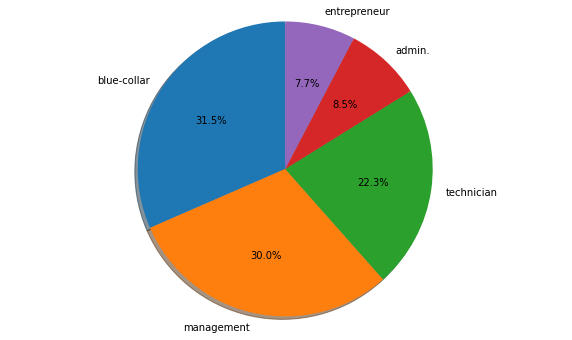

In [16]:
default_job = df_default.groupby('job')['balance'].count()
default_job = default_job.sort_values(ascending=False).head()
sizes = default_job.values
labels = default_job.index

fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

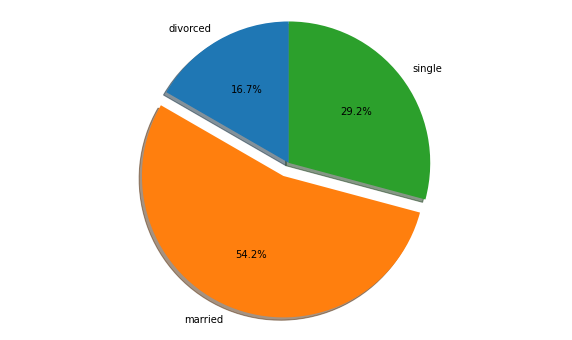

In [17]:
default_marital = df_default.groupby('marital')['balance'].count()
sizes = default_marital.values
labels = default_marital.index
explode = (0, 0.1, 0) 

fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [18]:
df_default.describe()

age      balance         day     duration    campaign  \
count  168.000000   168.000000  168.000000   168.000000  168.000000   
mean    40.130952   -61.803571   16.839286   344.589286    3.190476   
std      9.825154   827.742361    8.560689   284.155526    3.884488   
min     24.000000 -6847.000000    1.000000     8.000000    1.000000   
25%     32.000000  -344.000000    9.000000   125.750000    1.000000   
50%     39.500000     0.000000   17.000000   230.000000    2.000000   
75%     47.000000    65.500000   23.250000   525.250000    3.000000   
max     71.000000  5249.000000   31.000000  1558.000000   25.000000   

            pdays    previous  
count  168.000000  168.000000  
mean    19.410714    0.178571  
std     80.618517    0.930658  
min     -1.000000    0.000000  
25%     -1.000000    0.000000  
50%     -1.000000    0.000000  
75%     -1.000000    0.000000  
max    521.000000    8.000000

## Data Cleaning

In [19]:
def get_dummy_from_bool(row, column_name):
    ''' Returns 0 if value in column_name is no, returns 1 if value in column_name is yes'''
    return 1 if row[column_name] == 'yes' else 0

def get_correct_values(row, column_name, threshold, df):
    ''' Returns mean value if value in column_name is above threshold'''
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = df[df[column_name] <= threshold][column_name].mean()
        return mean

def clean_data(df):
    '''
    INPUT
    df - pandas dataframe containing bank marketing campaign dataset
    
    OUTPUT
    df - cleaned dataset:
    1. columns with 'yes' and 'no' values are converted into boolean variables;
    2. categorical columns are converted into dummy variables;
    3. drop irrelevant columns.
    4. impute incorrect values
    '''
    
    cleaned_df = df.copy()
    
    #convert columns containing 'yes' and 'no' values to boolean variables and drop original columns
    bool_columns = ['default', 'housing', 'loan', 'deposit']
    for bool_col in bool_columns:
        cleaned_df[bool_col + '_bool'] = df.apply(lambda row: get_dummy_from_bool(row, bool_col),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = bool_columns)
    
    #convert categorical columns to dummies
    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
    
    for col in  cat_columns:
        cleaned_df = pd.concat([cleaned_df.drop(col, axis=1),
                                pd.get_dummies(cleaned_df[col], prefix=col, prefix_sep='_',
                                               drop_first=True, dummy_na=False)], axis=1)
    
    #drop irrelevant columns
    cleaned_df = cleaned_df.drop(columns = ['pdays'])
    
    #impute incorrect values and drop original columns
    cleaned_df['campaign_cleaned'] = df.apply(lambda row: get_correct_values(row, 'campaign', 34, cleaned_df),axis=1)
    cleaned_df['previous_cleaned'] = df.apply(lambda row: get_correct_values(row, 'previous', 34, cleaned_df),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = ['campaign', 'previous'])
    
    return cleaned_df

In [20]:
#clean the dataset
cleaned_df = clean_data(df)
cleaned_df.head()

age  balance  day  duration  default_bool  housing_bool  loan_bool  \
0   59     2343    5      1042             0             1          0   
1   56       45    5      1467             0             0          0   
2   41     1270    5      1389             0             1          0   
3   55     2476    5       579             0             1          0   
4   54      184    5       673             0             0          0   

   deposit_bool  job_blue-collar  job_entrepreneur  ...  month_mar  month_may  \
0             1                0                 0  ...          0          1   
1             1                0                 0  ...          0          1   
2             1                0                 0  ...          0          1   
3             1                0                 0  ...          0          1   
4             1                0                 0  ...          0          1   

   month_nov  month_oct  month_sep  poutcome_other  poutcome_success  \
0          0          0          0               0                 0   
1          0          0          0               0                 0   
2          0          0          0               0                 0   
3          0          0          0               0                 0   
4          0          0          0               0                 0   

   poutcome_unknown  campaign_cleaned  previous_cleaned  
0                 1               1.0               0.0  
1                 1               1.0               0.0  
2                 1               1.0               0.0  
3                 1               1.0               0.0  
4                 1               2.0               0.0  

[5 rows x 42 columns]

## Modeling

In [21]:
X = cleaned_df.drop(columns = 'deposit_bool')
y = cleaned_df[['deposit_bool']]
TEST_SIZE = 0.3
RAND_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

In [22]:

xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train.squeeze().values)

#calculate and print scores for the model for top 15 features
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('XGB accuracy score for train: %.3f: test: %.3f' % (
        accuracy_score(y_train, y_train_preds),
        accuracy_score(y_test, y_test_preds)))

XGB accuracy score for train: 0.912: test: 0.850


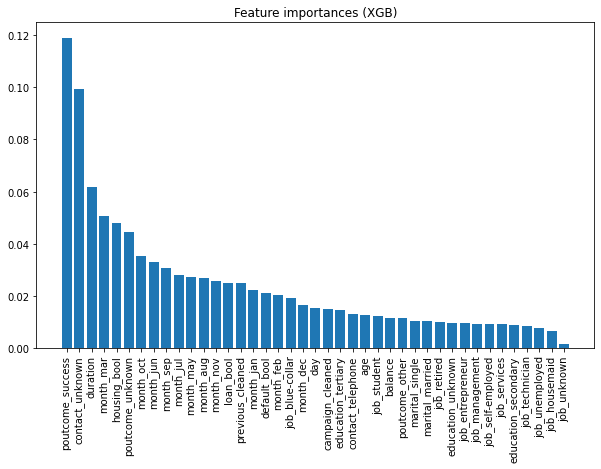

In [23]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances
plt.figure(figsize=(10,6))
x_pos = np.arange(0, len(xgb_feature_importances))
plt.bar(x_pos, xgb_feature_importances['score'])
plt.xticks(x_pos, xgb_feature_importances['name'])
plt.xticks(rotation=90)
plt.title('Feature importances (XGB)')

plt.show()

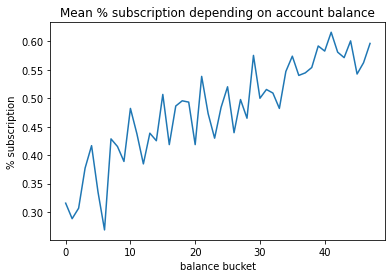

In [24]:
df_new = cleaned_df.copy()

#introduce new column 'balance_buckets' to  ''
df_new['balance_buckets'] = pd.qcut(df_new['balance'], 50, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_deposit = df_new.groupby(['balance_buckets'])['deposit_bool'].mean()

#plot
plt.plot(mean_deposit.index, mean_deposit.values)
plt.title('Mean % subscription depending on account balance')
plt.xlabel('balance bucket')
plt.ylabel('% subscription')
plt.show()

In [29]:
cleaned_df.groupby('poutcome_success')['deposit_bool'].mean()

poutcome_success
0    0.427212
1    0.913165
Name: deposit_bool, dtype: float64

In [30]:
cleaned_df.groupby('housing_bool')['deposit_bool'].mean()

housing_bool
0    0.570311
1    0.366408
Name: deposit_bool, dtype: float64

In [31]:
cleaned_df.groupby('loan_bool')['deposit_bool'].mean()

loan_bool
0    0.495259
1    0.331507
Name: deposit_bool, dtype: float64

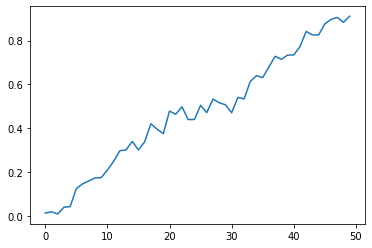

In [34]:
df_new = cleaned_df.copy()

#introduce new column 'balance_buckets' to  ''
df_new['duration_buckets'] = pd.qcut(df_new['duration'], 50, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_deposit = df_new.groupby(['duration_buckets'])['deposit_bool'].mean()
plt.plot(mean_deposit.index, mean_deposit.values)

In [39]:
cleaned_df.groupby('month_mar')['deposit_bool'].mean()

month_mar
0    0.463072
1    0.898551
Name: deposit_bool, dtype: float64

In [41]:
df.groupby(['month','deposit']).count()

age   job  marital  education  default  balance  housing  \
month deposit                                                              
apr   no        346   346      346        346      346      346      346   
      yes       577   577      577        577      577      577      577   
aug   no        831   831      831        831      831      831      831   
      yes       688   688      688        688      688      688      688   
dec   no         10    10       10         10       10       10       10   
      yes       100   100      100        100      100      100      100   
feb   no        335   335      335        335      335      335      335   
      yes       441   441      441        441      441      441      441   
jan   no        202   202      202        202      202      202      202   
      yes       142   142      142        142      142      142      142   
jul   no        887   887      887        887      887      887      887   
      yes       627   627      627        627      627      627      627   
jun   no        676   676      676        676      676      676      676   
      yes       546   546      546        546      546      546      546   
mar   no         28    28       28         28       28       28       28   
      yes       248   248      248        248      248      248      248   
may   no       1899  1899     1899       1899     1899     1899     1899   
      yes       925   925      925        925      925      925      925   
nov   no        540   540      540        540      540      540      540   
      yes       403   403      403        403      403      403      403   
oct   no         69    69       69         69       69       69       69   
      yes       323   323      323        323      323      323      323   
sep   no         50    50       50         50       50       50       50   
      yes       269   269      269        269      269      269      269   

               loan  contact   day  duration  campaign  pdays  previous  \
month deposit                                                             
apr   no        346      346   346       346       346    346       346   
      yes       577      577   577       577       577    577       577   
aug   no        831      831   831       831       831    831       831   
      yes       688      688   688       688       688    688       688   
dec   no         10       10    10        10        10     10        10   
      yes       100      100   100       100       100    100       100   
feb   no        335      335   335       335       335    335       335   
      yes       441      441   441       441       441    441       441   
jan   no        202      202   202       202       202    202       202   
      yes       142      142   142       142       142    142       142   
jul   no        887      887   887       887       887    887       887   
      yes       627      627   627       627       627    627       627   
jun   no        676      676   676       676       676    676       676   
      yes       546      546   546       546       546    546       546   
mar   no         28       28    28        28        28     28        28   
      yes       248      248   248       248       248    248       248   
may   no       1899     1899  1899      1899      1899   1899      1899   
      yes       925      925   925       925       925    925       925   
nov   no        540      540   540       540       540    540       540   
      yes       403      403   403       403       403    403       403   
oct   no         69       69    69        69        69     69        69   
      yes       323      323   323       323       323    323       323   
sep   no         50       50    50        50        50     50        50   
      yes       269      269   269       269       269    269       269   

               poutcome  
month deposit            
apr   no            346  
      yes 